# Plantations Extent widget

Shows the area of plantation in a country (adm0 level) visualised as a pie chart, where each type of plantation is represented as a different colour vs. non-plantation area. This widget only applies to a small number of countries. Plantations by SPECIES should be defauly

Data:

1. admn-0, -1, -2
2. polyname = 'plantations'
3. plantation type ('bound1') or species ('bound2')
4. plantation area (area_poly_aoi)
5. other areas (area_gadm28 - sum of others)

User Variables:

1. unit (ha/% of regions extent)
2. Adm0, 1, 2
3. Threshold

How to:

- collect gadm28 extent for region
- collect extent area for plantation subclasses
- Outside Plantations in ha = gadm28 - sum(plantation subclasses)
- Outside Plantations in % = 100 * { gadm28 - sum(plantation subclasses) / gadm28 }

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
def extent_queries(p_name, year, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

# By Plantation *Type*

In [3]:
# VARIABLES

thresh = 0            # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'          # 'BRA', 'IDN', 'MYS', 'COL', 'KHM', 'LBR', 'PER'
adm1 = None             # To rank admin 1 areas, set to None
adm2 = None                     # To rant admin 2 areas, specify an admin 1 level

extent_year = 2000     #extent data (2000 or 2010)

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [4]:
def plantations_type_queries(adm0, adm1=None, adm2=None, year='area_extent_2000', threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2}"
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql

In [5]:
# Get the sum of extent in region, grouped by TYPE
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = plantations_type_queries(adm0=adm0, adm1=adm1, adm2=adm2,
                               year=extent_year_dict[extent_year], threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantations_ha = r.json().get('data')
plantations_ha


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+AS+plantation_extent+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+bound1+ORDER+BY+plantation_extent+DESC
Status: 200


[{'bound1': 'Large industrial plantation',
  'plantation_extent': 4781184.802494563},
 {'bound1': 'Clearing/ very young plantation',
  'plantation_extent': 415829.0335399434},
 {'bound1': 'Mosaic of medium-sized plantations',
  'plantation_extent': 45769.13921111822},
 {'bound1': 'Mosaic of small-sized plantations',
  'plantation_extent': 2381.0843410491943}]

In [6]:
# Get total extent (using gadm28 p_name)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = extent_queries('gadm28', extent_year_dict[extent_year], adm0, adm1=None, adm2 = None, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent = r.json().get('data')
extent

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27
Status: 200


[{'total_area': 850033236.0091553, 'value': 566751560.1416798}]

In [7]:
#Calculate the cpombined plantation area, and populate size(ha) and label arrays

total_plantation_area = 0
sizes = []
labels = []

for p in plantations_ha:
    if p.get('plantation_extent') != 0:
        total_plantation_area += p.get('plantation_extent')
        sizes.append(p.get('plantation_extent'))
        labels.append(p.get('bound1'))
total_plantation_area


5245164.059586674

In [8]:
# calculate percentages relative to total plantation extent
plantation_percent = []

for s in sizes:
    if s != 0:
        plantation_percent.append(100*s/total_plantation_area)
plantation_percent

[91.1541516753115, 7.927855617402963, 0.8725969043325766, 0.04539580295295524]

In [9]:
#Calculate extent outside of plantations

other_areas = extent[0].get('value') - total_plantation_area
other_areas

561506396.0820931

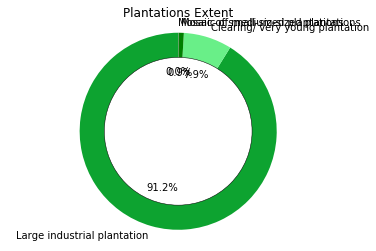

In [10]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
            
# Use the below if you wish to include 'Other areas' data (doesn't look great in most cases!)

"""
labels.append('Other areas')
sizes.append(other_areas)
"""

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title('Plantations Extent')
plt.show()

<a id='s16'></a>
### Dynamic Sentence for TYPE

In [11]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm2:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')
elif adm1:

    tmp = get_admin1_json(iso=adm0)
    adm1_to_name={}
    for row in tmp:
        adm1_to_name[row.get('adm1')] = row.get('name') 

In [12]:
#Dynamic sentence. For type.
if adm2:
    region_name = adm2_to_name[adm2]
elif adm1:
    region_name = adm1_to_name[adm1]
elif adm0:
    region_name = iso_to_countries[adm0]

print(f"The largest plantation type in {region_name} by area are ", end="")
print(f"{plantation_type_dict[plantations_ha[0].get('bound1')]} plantations, ", end="")
print(f"containing {plantations_ha[0].get('plantation_extent'):,.0f}ha of tree cover in. ", end="")

print(f"This represents {100*plantations_ha[0].get('plantation_extent')/ extent[0].get('value'):.2f}% ", end="")
print(f"of {region_name}'s total tree cover extent in {extent_year} ", end="")
print(f"where the canopy cover is greater than {thresh}%. ", end="")


The largest plantation type in Brazil by area are large industrial plantations, containing 4,781,185ha of tree cover in. This represents 0.84% of Brazil's total tree cover extent in 2000 where the canopy cover is greater than 0%. 

<a id='s17'></a>
# By Plantation *Species* (default)

In [13]:
# VARIABLES

thresh = 0            # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'          # 'BRA', 'IDN', 'MYS', 'COL', 'KHM', 'LBR', 'PER'
adm1 = None             # To rank admin 1 areas, set to None
adm2 = None                     # To rant admin 2 areas, specify an admin 1 level

extent_year = 2000     #extent data (2000 or 2010)

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [14]:
def plantations_species_queries(adm0, adm1=None, adm2=None, year='area_extent_2000', threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2}"
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM({year}) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql

In [15]:
# Get the sum of extent in region, grouped by TYPE
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = plantations_species_queries(adm0=adm0, adm1=adm1, adm2=adm2,
                                  year=extent_year_dict[extent_year], threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantations_ha = r.json().get('data')
plantations_ha


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+AS+plantation_extent+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+bound2+ORDER+BY+plantation_extent+DESC
Status: 200


[{'bound2': 'Wood fiber / timber', 'plantation_extent': 4251017.472964287},
 {'bound2': 'Recently cleared', 'plantation_extent': 415829.0335399434},
 {'bound2': 'Unknown', 'plantation_extent': 244621.9651652798},
 {'bound2': 'Fruit', 'plantation_extent': 151119.37168298662},
 {'bound2': 'Oil palm', 'plantation_extent': 88222.76972579956},
 {'bound2': 'Other mix', 'plantation_extent': 58905.92364119738},
 {'bound2': 'Rubber', 'plantation_extent': 35447.52286718041}]

In [16]:
# Get total extent (using gadm28 p_name)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = extent_queries('gadm28', extent_year_dict[extent_year], adm0, adm1=None, adm2 = None, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent = r.json().get('data')
extent

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27
Status: 200


[{'total_area': 850033236.0091553, 'value': 566751560.1416798}]

In [17]:
#Calculate the cpombined plantation area, and populate size(ha) and label arrays

total_plantation_area = 0
sizes = []
labels = []

for p in plantations_ha:
    if p.get('plantation_extent') != 0:
        total_plantation_area += p.get('plantation_extent')
        sizes.append(p.get('plantation_extent'))
        labels.append(p.get('bound2'))
total_plantation_area


5245164.059586674

In [18]:
# calculate percentages relative to total plantation extent
plantation_percent = []

for s in sizes:
    if s != 0:
        plantation_percent.append(100*s/total_plantation_area)
plantation_percent

[81.04641579694025,
 7.927855617402963,
 4.663761941214787,
 2.8811181112015594,
 1.6819830366326356,
 1.1230520718133505,
 0.675813424794452]

In [19]:
#Calculate extent outside of plantations

other_areas = extent[0].get('value') - total_plantation_area
other_areas

561506396.0820931

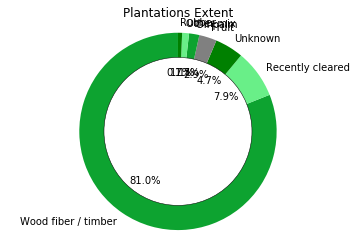

In [20]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
            
# Use the below if you wish to include 'Other areas' data (doesn't look great in most cases!)

"""
labels.append('Other areas')
sizes.append(other_areas)
"""

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title('Plantations Extent')
plt.show()

<a id='s18'></a>
### Dynamic Sentence for SPECIES

In [21]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm2:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')
elif adm1:

    tmp = get_admin1_json(iso=adm0)
    adm1_to_name={}
    for row in tmp:
        adm1_to_name[row.get('adm1')] = row.get('name') 

In [24]:
#Dynamic sentence. For species.
if adm2:
    region_name = adm2_to_name[adm2]
elif adm1:
    region_name = adm1_to_name[adm1]
elif adm2:
    region_name = iso_to_countries[iso]

print(f"In {region_name} {plantation_species_dict[plantations_ha[0].get('bound2')]} ", end="")
print(f"plantations represent the largest plantation type by species in {extent_year}, ", end="")
print(f"spanning {plantations_ha[0].get('plantation_extent'):,.0f}ha ", end="")
print(f"where the canopy cover is greater than {thresh}%. ", end="")

if len(plantations_ha)-1 > 1:
    print(f"The remaining {(total_plantation_area - plantations_ha[0].get('plantation_extent')):,.0f}ha ", end="")
    print(f"of tree cover is distributed between {len(plantations_ha)-1} other plantation types. ", end="")
elif len(plantations_ha)-1 == 1:
    print(f"The remaining {(total_plantation_area - plantations_ha[0].get('plantation_extent')):,.0f}ha ", end="")
    print(f"of tree cover is found in {plantations_ha[1].get('bound2')} plantations. ", end="")
elif len(plantations_ha)-1 == 0:
    print(f"All tree cover in {region_name} is found in this plantatio type. ", end="")

In Brazil wood fiber and timber plantations represent the largest plantation type by species in 2000, spanning 4,251,017ha where the canopy cover is greater than 0%. The remaining 994,147ha of tree cover is distributed between 6 other plantation types. 